In [1]:
import torch
from torch_geometric.data import Data
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import optuna

from models import GraphTransformerNormalizingFlow
from parameters import GraphTransformerNormalizingFlowParameters, TrainingParameters
from datautils import get_morning_data, normalize_data, generate_edges, generate_relational_edges, load_best_parameters, get_full_data, label_anomalies
from training import save_model, load_model, train_stae, compute_anomaly_threshold_rstae, test_model, threshold_anomalies, fill_result_df, test_rstae
from metrics import calculate_accuracy, crash_detection_delay, calculate_tp_fp, find_thresholds, find_delays, find_percent, discrete_fp_delays, generate_anomaly_labels, calculate_auc
import torch.nn as nn
from tqdm import tqdm

import random
import os

/media/vanderbilt/home/zulqarnain/anaconda3/envs/traffic-anomaly/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def edge_index_to_adj(edge_index, num_nodes):
    # Initialize an NxN zero matrix
    adj_matrix = torch.zeros((num_nodes, num_nodes), dtype=torch.float32)
    
    # For each edge in edge_index, set adj_matrix[source, target] = 1
    adj_matrix[edge_index[0], edge_index[1]] = 1
    
    adj_matrix=adj_matrix+adj_matrix.t()
    
    return adj_matrix

def sequence_gtnf(data, timesteps, hide_anomalies=False):
    sequence = []
    relational_edges, relations = generate_relational_edges(milemarkers=list(range(49)), timesteps=timesteps)
    static_edges = generate_edges(milemarkers=list(range(49)))
    
    adj_matrix =  edge_index_to_adj(static_edges, 196)
    days = data['day']
    anomalies = data['anomaly']
    data_vals = data[['occ', 'speed', 'volume']]
    unix = data['unix_time']
    unique_times = np.unique(data['unix_time'])
    kept_indices = []

    for index, t in enumerate(tqdm(unique_times[timesteps:])): # skip first 'timesteps'
        adj_matrices = []
        feature_matrices = []
        anomaly_matrices = []

        backward_index = range(index-1, index-timesteps-1, -1)
        backward_times = [unique_times[i] for i in backward_index]
        curr_day = np.unique(data[data['unix_time']==backward_times[-1]]['day'])[0]
        contains_anomaly = np.any([np.unique(data[data['unix_time']==i]['anomaly'])[0] for i in backward_times])
        is_curr_day = np.all([np.unique(data[data['unix_time']==i]['day'])[0]==curr_day for i in backward_times])

        if (hide_anomalies and contains_anomaly) or not is_curr_day:
            continue
        
        kept_indices.append(index+timesteps)

        for i in backward_times:
            # Node feature matrix
            node_features = data[data['unix_time']==i][['occ', 'speed', 'volume']].to_numpy()
            feature_matrices.append(torch.tensor(node_features, dtype=torch.float32))
            
            # Adjacency matrix (static for each time step)
            adj_matrices.append(adj_matrix)  # Assuming static_edges is in PyTorch Geometric format
            
            # Anomaly matrix (if any)
            anomaly_matrix = data[data['unix_time']==i]['anomaly'].to_numpy()
            anomaly_matrices.append(torch.tensor(anomaly_matrix, dtype=torch.float32))

        # Stack the matrices to create tensors for the sequence
        adj_matrices = torch.stack(adj_matrices)
        feature_matrices = torch.stack(feature_matrices)
        anomaly_matrices = torch.stack(anomaly_matrices)

        # Pack into a torch_geometric Data object
        data_new = Data(
            x=feature_matrices.unsqueeze(0),  # Node features for the window
            adj=adj_matrices.unsqueeze(0),    # Adjacency matrices for the window
            y=anomaly_matrices.unsqueeze(0)   # Anomalies for the window (optional)
        )
        
        sequence.append(data_new)

    return sequence, kept_indices


In [3]:
training_params = TrainingParameters(
    learning_rate=0.001,
    batch_size=256,
    timesteps=8,
    n_epochs=100,
)

In [17]:

train_data, test_data, _ = get_full_data()
train_data = normalize_data(train_data)
train_data = label_anomalies(train_data)
train_sequence, kept_train_indices = sequence_gtnf(train_data, training_params.timesteps)

100%|██████████| 13432/13432 [04:44<00:00, 47.20it/s]


In [5]:
num_features = 3
num_nodes = 196


In [9]:
from torch_geometric.data import DataLoader
dataset_size = len(train_sequence)
train_size = int(0.8 * dataset_size)
val_size = dataset_size - train_size

# Sequentially split the dataset
train_dataset = train_sequence[:train_size]
val_dataset = train_sequence[train_size:]

# train_dataloader = DataLoader(train_dataset, batch_size=training_params.batch_size, shuffle=True)
# val_dataloader = DataLoader(val_dataset, batch_size=training_params.batch_size, shuffle=True)
train_dataloader = DataLoader(train_sequence, batch_size=training_params.batch_size, shuffle=False)


/media/vanderbilt/home/zulqarnain/anaconda3/envs/traffic-anomaly/lib/python3.11/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [10]:
len(val_dataset)

2667

In [11]:
len(train_dataset)

10667

In [16]:
len(kept_train_indices)

4757

In [13]:
test_data = normalize_data(test_data)
test_data = label_anomalies(test_data)
test_data, kept_train_indices = sequence_gtnf(test_data, training_params.timesteps)

100%|██████████| 4792/4792 [00:51<00:00, 93.74it/s] 


In [14]:
len(test_data)

4757

In [7]:
# model_params = {
#     'input_features': num_features,
#     'num_sensors': num_nodes,
#     'hidden_dim': 128,
#     'num_heads': 1,
#     'num_transformer_layers': 2,
#     'output_dim': 64,
#     'num_gcn_layers': 2,
#     'flow_layers': 3,

# }
model_params = {
    'input_features': num_features,
    'num_sensors': num_nodes,
    'hidden_dim': 128,
    'num_heads': 1,
    'num_transformer_layers': 2,
    'output_dim': 64,
    'num_gcn_layers': 2,
    'flow_layers': 4,

}



In [8]:
model= GraphTransformerNormalizingFlow(**model_params)

In [9]:
# Define the optimizer for GAENF
optimizer = torch.optim.Adam(
    model.parameters(), 
    lr=training_params.learning_rate
)

print('FRAMEWORK LOADED')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
# Set up early stopping parameters
patience = 5  # Number of epochs to wait for improvement
best_val_loss = float('inf')  # Best validation loss starts as infinity
epochs_without_improvement = 0  # Counter for epochs without improvement

for epoch in range(training_params.n_epochs):
    model.train()  # Set model to training mode
    
    total_loss = 0
    nbatches_processed = 0

    # Training loop
    for batch_idx, batch in enumerate(train_dataloader):
        nbatches_processed += 1
        feature_matrices = batch.x.to(device)  # Shape: [B, W, N, F]
        adj_matrices = batch.adj.to(device)    # Shape: [B, W, N, N]
        
        # Extract features using the GAENF model
        anomaly_scores = model(feature_matrices, adj_matrices)  # Shape: [B, W, N]
        
        
        # Compute log probability (negative log-likelihood)
        loss = torch.mean(torch.mean(torch.mean(anomaly_scores,dim=2),dim=1),dim=0)  # NLL to be minimized
        total_loss += loss.item()

        # Backward pass and optimization step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        del feature_matrices, adj_matrices, anomaly_scores
        torch.cuda.empty_cache()
        
        
        print(f" Epoch {epoch + 1}/{training_params.n_epochs}, Batch {batch_idx + 1}/{len(train_dataloader)}, Loss: {loss.item():.4f}")
    
    print(f" Epoch {epoch + 1}/{training_params.n_epochs}, Total Training Loss: {total_loss:.4f}")
    avg_train_loss = total_loss / nbatches_processed
    # Validation step
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for val_batch in train_dataloader:
            feature_matrices = val_batch.x.to(device)
            adj_matrices = val_batch.adj.to(device)
            
            # Extract features for validation
            anomaly_scores = model(feature_matrices, adj_matrices)
            
            # Calculate validation loss
            val_loss += torch.mean(torch.mean(torch.mean(anomaly_scores,dim=2),dim=1),dim=0) 

    avg_val_loss = val_loss / len(train_dataloader)
    print(f"Epoch {epoch + 1}/{training_params.n_epochs}, Validation Loss: {avg_val_loss:.4f}")

    # Early Stopping: Check if validation loss improved
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0
        print(f" Validation loss improved. Best validation loss: {best_val_loss:.4f}")
        model_path = f'../models/GTNF/'
        if not os.path.exists(model_path):
            os.makedirs(model_path)

        
        torch.save(model.state_dict(), model_path+f'GAENF_block.pt')
    else:
        epochs_without_improvement += 1
        print(f", No improvement for {epochs_without_improvement} epochs.")

    # Check if early stopping condition is met
    if epochs_without_improvement >= patience or epoch == training_params.n_epochs - 1:
        print(f" Early stopping triggered.")
        
        break



FRAMEWORK LOADED


 Epoch 1/100, Batch 1/53, Loss: 59.6630
 Epoch 1/100, Batch 2/53, Loss: 58.9035
 Epoch 1/100, Batch 3/53, Loss: 58.2198
 Epoch 1/100, Batch 4/53, Loss: 57.5845
 Epoch 1/100, Batch 5/53, Loss: 56.9832
 Epoch 1/100, Batch 6/53, Loss: 56.3792
 Epoch 1/100, Batch 7/53, Loss: 55.7655
 Epoch 1/100, Batch 8/53, Loss: 55.1309
 Epoch 1/100, Batch 9/53, Loss: 54.4561
 Epoch 1/100, Batch 10/53, Loss: 53.7407
 Epoch 1/100, Batch 11/53, Loss: 52.9524
 Epoch 1/100, Batch 12/53, Loss: 52.0917
 Epoch 1/100, Batch 13/53, Loss: 51.1563
 Epoch 1/100, Batch 14/53, Loss: 50.1186
 Epoch 1/100, Batch 15/53, Loss: 48.9634
 Epoch 1/100, Batch 16/53, Loss: 47.6791
 Epoch 1/100, Batch 17/53, Loss: 46.2458
 Epoch 1/100, Batch 18/53, Loss: 44.6223
 Epoch 1/100, Batch 19/53, Loss: 42.7786
 Epoch 1/100, Batch 20/53, Loss: 40.6791
 Epoch 1/100, Batch 21/53, Loss: 38.3477
 Epoch 1/100, Batch 22/53, Loss: 35.7511
 Epoch 1/100, Batch 23/53, Loss: 32.8456
 Epoch 1/100, Batch 24/53, Loss: 29.5553
 Epoch 1/100, Batch 25/53

In [10]:
model.load_state_dict(torch.load(model_path+f'GAENF_block.pt'))

<All keys matched successfully>

In [11]:
import training

In [12]:
import importlib
importlib.reload(training)
threshold_anomalies=training.compute_anomlay_threshold_gtnf(train_dataloader, model, device, method='mean')

In [13]:
threshold_anomalies[0].max()

-64.70779

In [14]:
_, df_test_data, _ = get_full_data()
test_data = normalize_data(df_test_data)
test_data = label_anomalies(test_data)
test_data, kept_test_indices = sequence_gtnf(test_data, training_params.timesteps, hide_anomalies=False)

100%|██████████| 4792/4792 [00:51<00:00, 92.66it/s] 


In [15]:
threshold_anomalies[1]

-78.26546776294708

In [40]:
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=False)
importlib.reload(training)

all_node_true_labels, all_node_pred_labels, all_graph_true_labels, all_graph_pred_labels, node_probs,graph_probs =training.test_gtnf(test_dataloader, model, device, threshold_anomalies[0], threshold_anomalies[1])

/media/vanderbilt/home/zulqarnain/anaconda3/envs/traffic-anomaly/lib/python3.11/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [41]:

all_graph_pred_labels=np.stack(all_graph_pred_labels)
all_graph_true_labels=np.stack(all_graph_true_labels)
all_node_pred_labels=np.stack(all_node_pred_labels)
all_node_true_labels=np.stack(all_node_true_labels)
node_probs=np.stack(node_probs)
graph_probs=np.stack(graph_probs)   

print(all_graph_pred_labels.shape)
print(all_graph_true_labels.shape)
print(all_node_pred_labels.shape)
print(all_node_true_labels.shape)

(4757,)
(4757,)
(4757, 196)
(4757, 196)


In [18]:
anomaly_labels = generate_anomaly_labels(df_test_data, kept_test_indices)

# Whether a crash was reported at each time
crash_reported = df_test_data['crash_record'].to_numpy()[0::196][kept_test_indices]

/media/vanderbilt/home/zulqarnain/freeway-anomaly-detection/code/metrics.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data.loc[(test_data['unix_time'] - human_label_time <= 1800) & (test_data['unix_time'] - human_label_time >= 0), 'anomaly'] = 1
/media/vanderbilt/home/zulqarnain/freeway-anomaly-detection/code/metrics.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data.fillna(0, inplace=True)


In [19]:
import metrics
importlib.reload(metrics)
delay_results,thresholds = metrics.find_delays_nll(threshold_anomalies[0], node_probs, anomaly_labels, crash_reported,changed_sr=True, sr=0.5)
delay_results=np.array(delay_results)


# delays, detects = crash_detection_delay(all_node_pred_labels, crash_reported, sr=0.5) 



100%|██████████| 1000/1000 [00:30<00:00, 32.93it/s]
/media/vanderbilt/home/zulqarnain/anaconda3/envs/traffic-anomaly/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/media/vanderbilt/home/zulqarnain/anaconda3/envs/traffic-anomaly/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/media/vanderbilt/home/zulqarnain/anaconda3/envs/traffic-anomaly/lib/python3.11/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/media/vanderbilt/home/zulqarnain/anaconda3/envs/traffic-anomaly/lib/python3.11/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/media/vanderbilt/home/zulqarnain/anaconda3/envs/traffic

In [29]:
importlib.reload(metrics)
metrics.discrete_fp_delays_nll(threshold_anomalies[0], node_probs, anomaly_labels, crash_reported)

100%|██████████| 1000/1000 [00:30<00:00, 33.15it/s]

Found FPR of 0.00997506234413965 for 0.01
Found FPR of 0.02493765586034913 for 0.025
Found FPR of 0.04987531172069826 for 0.05
Found FPR of 0.100166251039069 for 0.1
Found FPR of 0.19950124688279303 for 0.2
Found FPR of 0.2502078137988362 for 0.25
FPR 1% gives mean delay of nan +/- nan while missing 1.0%.
FPR 2.5% gives mean delay of 4.333333333333333 +/- 7.027722880769339 while missing 0.75%.
FPR 5% gives mean delay of -2.0 +/- 9.308214498111715 while missing 0.41666666666666663%.
FPR 10% gives mean delay of -7.75 +/- 6.832825184358224 while missing 0.33333333333333337%.
FPR 20% gives mean delay of -11.0 +/- 5.9066817155564495 while missing 0.25%.
FPR 25% gives mean delay of -12.444444444444445 +/- 5.1177493124117905 while missing 0.25%.



/media/vanderbilt/home/zulqarnain/anaconda3/envs/traffic-anomaly/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/media/vanderbilt/home/zulqarnain/anaconda3/envs/traffic-anomaly/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/media/vanderbilt/home/zulqarnain/anaconda3/envs/traffic-anomaly/lib/python3.11/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/media/vanderbilt/home/zulqarnain/anaconda3/envs/traffic-anomaly/lib/python3.11/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/media/vanderbilt/home/zulqarnain/anaconda3/envs/traffic-anomaly/lib/python3.11/site-packages/numpy/core/_m

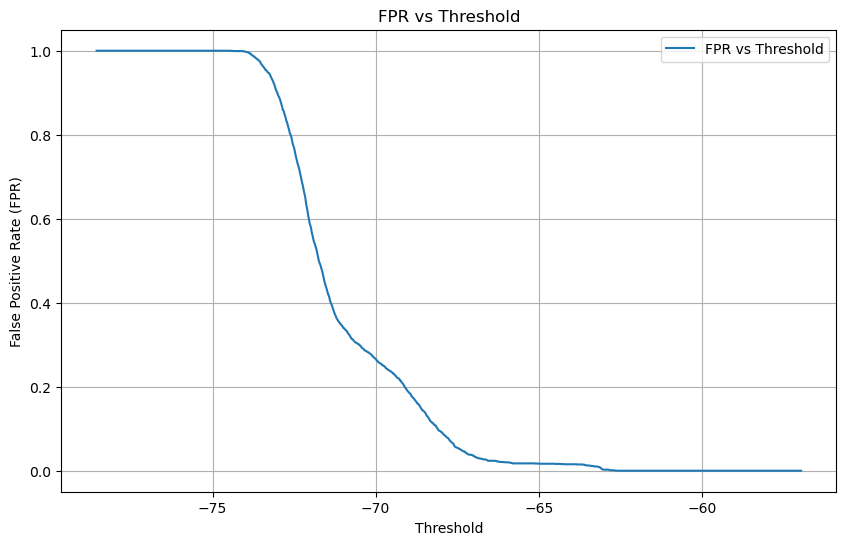

In [22]:
fpr = thresholds[:, 0]  # 0th axis (FPR)
thresholds = thresholds[:, 1]  # 1st axis (thresholds)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(thresholds, fpr, label='FPR vs Threshold')
plt.xlabel('Threshold')
plt.ylabel('False Positive Rate (FPR)')
plt.title('FPR vs Threshold')
plt.grid(True)
plt.legend()
plt.show()

In [23]:
delay_df = pd.DataFrame(delay_results, columns=['FPR', 'Mean Delay', 'Std Delay', 'Found Percent'])

In [24]:
delay_df

,FPR,Mean Delay,Std Delay,Found Percent
0,0.0,NaN,NaN,0.0
1,0.0,30.0,0.0,0.0
2,0.0,30.0,0.0,0.0
3,0.0,30.0,0.0,0.0
4,0.0,30.0,0.0,0.0
...,...,...,...,...
96,0.0,30.0,0.0,0.0
97,0.0,30.0,0.0,0.0
98,0.0,30.0,0.0,0.0
99,0.0,30.0,0.0,0.0


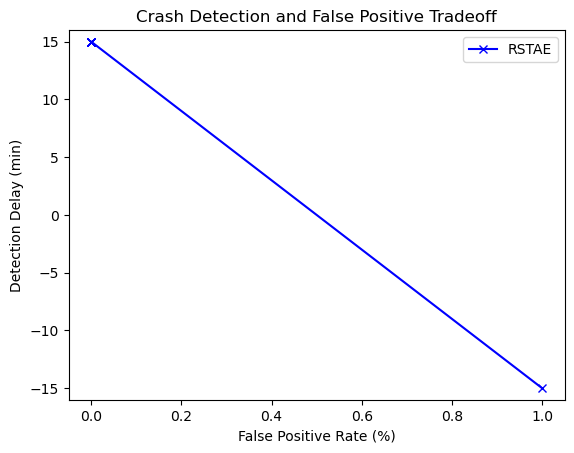

In [25]:
x_values = delay_df['FPR']
y_values = delay_df['Mean Delay'] / 2
std_values = delay_df['Std Delay'] / 2

plt.plot(x_values, y_values, color='blue', label='RSTAE', marker='x')

lower_bound = y_values - std_values  # 1.96 is the z-score for 95% confidence interval
upper_bound = y_values + std_values

plt.fill_between(x_values, lower_bound, upper_bound, color='blue', alpha=0.2)
plt.ylim(-16, 16)
# plt.xlim(-0.01,1)
plt.xlabel("False Positive Rate (%)")
plt.ylabel("Detection Delay (min)")
plt.title("Crash Detection and False Positive Tradeoff")
plt.legend()
plt.show()

In [26]:
calculate_auc(node_probs, anomaly_labels)

0.7142560266001663

In [27]:
delay_df.sort_values(by='FPR', ascending=False)

,FPR,Mean Delay,Std Delay,Found Percent
100,1.0,-30.0,0.0,1.0
64,0.0,30.0,0.0,0.0
74,0.0,30.0,0.0,0.0
73,0.0,30.0,0.0,0.0
72,0.0,30.0,0.0,0.0
...,...,...,...,...
31,0.0,30.0,0.0,0.0
30,0.0,30.0,0.0,0.0
29,0.0,30.0,0.0,0.0
28,0.0,30.0,0.0,0.0


In [39]:
crash_reported.shape
# anomaly_labels.shape

(4757,)

In [42]:
import metrics
import importlib
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
importlib.reload(metrics)

fpr, tpr, thresholds = roc_curve(all_node_true_labels.reshape(-1), node_probs.reshape(-1))
node_auc = auc(fpr, tpr)
fpr, tpr, thresholds = roc_curve(all_graph_true_labels.reshape(-1), graph_probs.reshape(-1))
graph_auc=roc_auc_score(all_graph_true_labels, graph_probs)

print(f"Node AUC: {node_auc:.4f}, Graph AUC: {graph_auc:.4f}")

node_accuracy=accuracy_score(all_node_true_labels, all_node_pred_labels)
graph_accuracy=accuracy_score(all_graph_true_labels, all_graph_pred_labels)
print(f"Node Accuracy: {node_accuracy:.4f}, Graph Accuracy: {graph_accuracy:.4f}")

node_precision=precision_score(all_node_true_labels.reshape(-1), all_node_pred_labels.reshape(-1))
graph_precision=precision_score(all_graph_true_labels.reshape(-1), all_graph_pred_labels.reshape(-1))

print(f"Node Precision: {node_precision:.4f}, Graph Precision: {graph_precision:.4f}")

node_recall=recall_score(all_node_true_labels.reshape(-1), all_node_pred_labels.reshape(-1))
graph_recall=recall_score(all_graph_true_labels.reshape(-1), all_graph_pred_labels.reshape(-1))

print(f"Node Recall: {node_recall:.4f}, Graph Recall: {graph_recall:.4f}")

node_f1=f1_score(all_node_true_labels.reshape(-1), all_node_pred_labels.reshape(-1))
graph_f1=f1_score(all_graph_true_labels.reshape(-1), all_graph_pred_labels.reshape(-1))

print(f"Node F1: {node_f1:.4f}, Graph F1: {graph_f1:.4f}")







Node AUC: 0.5768, Graph AUC: 0.6600
Node Accuracy: 0.3477, Graph Accuracy: 0.4530
Node Precision: 0.7054, Graph Precision: 1.0000
Node Recall: 0.0336, Graph Recall: 0.0015
Node F1: 0.0641, Graph F1: 0.0031
